# Data re-uploading for a single-qubit universal classifier

## A new model for Quantum Machine Learning with one or few qubits


__Contributors__:
Adrián Pérez-Salinas from _QUANTIC_ group at Barcelona Supercomputing Center (BSC) and Universitat de Barcelona (UB)

### Abstract
In this tutorial I will tackle the a problem of supervised machine learning. I will show that one qubit has got the sufficient computational power as to classify data in two or more classes. The key idea that must be understood for this fact is *re-uploading*. Re-uploading classical data to the quantum circuit via unitary operations allows to classify any kind of data into any number of classes with only one qubit. This idea can be extended to more qubits, and there exists a trade-off between the number of qubits and the number of times of re-upoading. This tutorial is based in the work in [1].

### Introduction
Machine Learning is one of the most useful applications found in computation, and it has been in recent years 
developed and implemented in many different circumstances. Nowadays it is used broadly for solving all possible kinds of problems. The main branch of Machine Learning, where we will focus, is known as Supervised Machine Learning. This paradigm consists in classifying data with a label from a given list. Every time we mention Machine Learning, we took for granted that it is supervised.

Quantum Machine Learning (QML from now on) is one of the most promising areas in the field of Quantum Computing. In recent years many theoretical breakthroughs have been achieved. There are two main strategies one can follow when applyting Quantum Computing to Machine Learning. Some proposals take advantage of the computational capabilities of Quantum Computing for performing classical tasks, as in Ref. [[2](https://arxiv.org/abs/1806.11463)]. Some other approaches tackle a Machine Learning problem in quantum ways. These methods can be still be inspired in classical classification algorithms [3,4] or make use of quantum parameterized circuits [5,6]. However, it is not clear how to build a model for Machine Learning performing as classical models. 

One of the most important obstacles we find in QML is the *no-cloning* theorem [7]. In general, it is not possible to copy some data encoded in a quantum state. Therefore, if we want to perform two different calculations with the same data we have to store it in a classical memory or own several copies of the quantum state. Classical models do not need to deal with this problem. For instance, neural networks perform series of calculations with the same input. 

<img src="Neural_network.png" width="220"> 
*Fig. 1: Neural network model with one hidden layer. Every neuron in the hidden layer (squares) receives the input from the previous layer and process the data.*
<br>

We present now a QML model that makes use of quantum circuits for classifying any data [1]. The circuits work for only one qubit, although the model can be extended to circuits with more qubits. The key feature of this model is that the data we want to classify is stored in a classical memory and is introduced into the circuit via unitary operations. Notice that the data is processed in different steps sequentially. This is a key difference to Neural Networks, where data is processed in parallel. 

<img src="Quantum_scheme.png" width="300"> 
*Fig. 2: Model for the Quantum Classifier. Every processing unit (squares) is a unitary operation receiving information from the current quantum state and the input, introduced classically.*
<br>


### Structure of a single-qubit classifier
Following the scheme from Fig. 2, we can describe the output quantum state as the result of the circuit in Fig. 3. The gates $U(\vec x)$ introduce the classical input into the circuit, while the gates $U(\vec{\phi_i})$ process that information. Notice that there are $N$ different $\vec{\phi_i}$, that is, the way of processing information will depend on some parameters that we must optimize. 

<img src="reuploading_circuit.png" width="500"> 
*Fig. 3: Circuit for the single-qubit classifier model. Every $U$ is a non-specified unitary gate that introduces either classical input ($\vec x$) or quantum processing ($\vec\phi_i$)*
<br>

To this point, we can rearrange $U(\vec x)$ and $U(\vec{\phi_i})$ into one common gate that will be

$$
L(i) = U3(\vec{\theta}_i + \vec{w}_i \circ \vec x),
$$

where $\vec{w}_{i}\circ\vec{x}=\left(w_{i}^{1}x^{1},w_{i}^{2}x^{2},w_{i}^{3}x^{3}\right)$ is the Hadamard product and $U3$ is the usual gate from *IBMQ*

$$
U3(\theta, \phi, \lambda) = \begin{pmatrix}
\cos(\theta / 2) & -\sin(\theta / 2) e^{i\lambda} \\ \sin(\theta / 2) e^{i\phi} & \cos(\theta/2) e^{i\lambda} e^{i\phi}
\end{pmatrix}.
$$

After applying many different $L(i)$ gates the final result will be

$$
|\psi (\vec x; \vec\theta, \vec w)\rangle = \prod_{i = 0}^L U3(\vec{\theta}_i + \vec{w}_i \circ \vec x)
$$

In this tutorial we will focus on classyfing points in a plane. Thus, every unitary gate will have 5 parameters $(p_0, \ldots, p_4)$ to optimize and the explicit form of the gates is

$$
U3(\theta, \phi, \lambda) \rightarrow U3(p_0 x_0 + p_1, p_2 x_1 + p_3, p_4)
$$


### Measurement and optimizing 
We mention that we must optimize the parameters in order to achieve a classifier. We need to generate a cost function. For doing so, we take the labels of the dataset and assign them to a quantum state. Now we will classify a binary dataset, so the obvious choice is to take the states of the computational basis $| 0 \rangle$ and $| 1 \rangle$. Roughly speaking, we want a cost function such that if the label is $0$ $(1)$, the quantum state will be close to $| 0 \rangle$ ($| 1 \rangle$). We choose the cost function

$$
\chi^2(\vec p) = \frac{1}{M}\sum_{\mu = 1}^M (1 - |\langle \mu | \psi(\vec x, \vec p)\rangle|^2)^2
$$

In principle, the label states $|\mu\rangle$ can be substituted by some other states, as we will see later.

Now we have to deal with the problem of measuring the fidelity of two states. For doing so we will use the SWAP test.

#### SWAP test
The SWAP test is a useful tool for measuring fidelities between states. Given two states $| \alpha \rangle$ and $| \beta \rangle$, the way of measuring their relative fidelity is by performing the circuit from Fig. 4. The fidelity can be directly computed with

$$
|\langle \alpha | \beta \rangle |^2 = 2 P_0 - 1 = 1 - 2 P_1 
$$

where $P_i$ is the probability of measuring $i$ in the computational basis. 

<img src="swap_test.png" width="300"> 
*Fig. 4: Circuit for the swap test. $| \alpha \rangle$ and $| \beta \rangle$ are unknown states but it is possible to compute their relative fidelity using this circuit.*
<br>

#### Optimization
There are lots of different methods for minimizing function. In this tutorial we let *scipy* do all the work. *IBMQ's aqua* uses also *scipy* as a subroutine for optimizing circuits. In this case, we found that the Powell method is the one that fits best our problem.

Optimization will be done using the *qasm simulator* as the number of calculations we must perform is large and quantum devices have got some qeues we have to respect. As a matter of fact, we will use a quantum device only for checking whether they can or cannot classify our data.

## The Code

Now we will start with the tutorial itself. 

First step is to import some auxiliary generic packages for Python. The `functions_aux` file is an adjunct with functions for plotting figures.

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import itertools
from scipy.optimize import minimize

from functions_aux import *

It is important to import also a few qiskit functions. I define also which devices I want to use. In this case, I chose the 'ibmq_ourense' because Ourense is my grandma's hometown, but any other device should work too. Do not forget to call the `IBMQ.load_account()` function for using quantum processors.

In [73]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ, transpile
from qiskit.providers.aer import QasmSimulator

IBMQ.load_account()

simulator='qasm_simulator'
quantum_device='ibmq_ourense'

/home/adrianps/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


### First problem: Classifying points In and Outside a Circle

We will tackle now a very simple problem: we want to know whether a point from a plane is inside or outside the circle. Our training dataset will be a grid specified below. Yellow points are inside the circle and blue are outside. The labels are $0$ for *out* and $1$ for *in*.


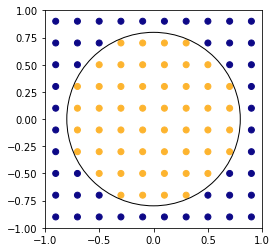

In [74]:
grid = 10
x = np.linspace(-.9,.9,grid)
X = list(itertools.product(x, x))
X_train = np.asfarray(X)
Y_train = circle_labels(X_train)

fig = draw_circle((X_train, Y_train))

Now it is time to create the circuit as a combination of adjustable unitary gates and the swap test. The $U$ gate is as explained before.
<img src="circuit_circle.png" width="400"> 
*Fig. 4: Circuit for the classification of a circle. The $X?$ gate will appear only if the point is inside the circle.*
<br>

We here define the circuit and another function for computing the fidelity with the $|0\rangle$ state. This will be useful later.

We define also the cost function for this problem.

In [80]:
def measurement_circle(x, y, parameters, device, err_like_dev=None):
    if len(parameters) % 5 != 0:
        raise ValueError('The number of parameters is not correct')
    layers = len(parameters) // 5
    parameters = parameters.reshape(layers, 5)
    C = QuantumCircuit(3,1)
    if y == 1:
        C.x(1)
    C.h(2)
    for l in range(layers):
        C.u3(parameters[l,0] * x[0] + parameters[l, 1], parameters[l, 2] * x[1] + parameters[l, 3], parameters[l, 4], 0)
        
    C.cswap(2, 0, 1)
    C.h(2)
    C.measure([2], [0])
    C.draw()
    # Select the QasmSimulator from the Aer provider
    try:
        backend = Aer.get_backend(device)
    except:
        provider = IBMQ.get_provider()#hub='ibm-q')
        backend=provider.get_backend(device)  
        C=transpile(C, backend=backend, optimization_level=1) # Sacar layout y pasarlo como argumento después


    # Execute and get counts
    sh = 1024
    if err_like_dev!= None:
        result = execute(C, backend, shots=sh, noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
    else:
        result = execute(C, backend, shots=sh, optimization_level = 1).result()
    counts = result.get_counts(C)
    fidelity = 2 * counts['0'] / sh - 1
    return fidelity


def check_circle(X, parameters, device, err_like_dev=None):
    noise_objects=None
    if err_like_dev!= None:
        provider = IBMQ.get_provider()#hub='ibm-q')
        err_device = provider.get_backend(err_like_dev)
        properties = err_device.properties()
        coupling_map = err_device.configuration().coupling_map
        noise_model = noise.device.basic_device_noise_model(properties)
        basis_gates = noise_model.basis_gates
        noise_objects = noise_model, coupling_map, basis_gates
    Fidelities = np.zeros(len(X))
    for i,x in enumerate(X):
         Fidelities[i]= measurement_circle(x, 1, parameters, device)
    #for y in range(2):
        #Fidelities[y] = measurement_circle(x, y, parameters, device)
        
    return Fidelities
    
    
def cost_function_circle(parameters, Data, device, err_like_dev=None):
    noise_objects=None
    if err_like_dev!= None:
        provider = IBMQ.get_provider()#hub='ibm-q')
        err_device = provider.get_backend(err_like_dev)
        properties = err_device.properties()
        coupling_map = err_device.configuration().coupling_map
        noise_model = noise.device.basic_device_noise_model(properties)
        basis_gates = noise_model.basis_gates
        noise_objects = noise_model, coupling_map, basis_gates
    
    X = Data[0]
    Y = Data[1]
    chi2 = 0
    for x, y in zip(X, Y):
        chi2 += (1 - measurement_circle(x, y, parameters, device))**2
        
    return chi2 / len(Y)

In [71]:
help(transpile)

Help on function transpile in module qiskit.compiler.transpile:

transpile(circuits, backend=None, basis_gates=None, coupling_map=None, backend_properties=None, initial_layout=None, seed_transpiler=None, optimization_level=None, pass_manager=None, callback=None, output_name=None)
    Transpile one or more circuits, according to some desired transpilation targets.
    
    All arguments may be given as either singleton or list. In case of list,
    the length must be equal to the number of circuits being transpiled.
    
    Transpilation is done in parallel using multiprocessing.
    
    Args:
        circuits (QuantumCircuit or list[QuantumCircuit]):
            Circuit(s) to transpile
    
        backend (BaseBackend):
            If set, transpiler options are automatically grabbed from
            backend.configuration() and backend.properties().
            If any other option is explicitly set (e.g. coupling_map), it
            will override the backend's.
    
            Not

Now it is time to minimize. We must specify here the number of `layers`, that is how many times we want to re-upload and process the data. For this problem, 2 times is enough. Notice that this is the slowest part of the notebook. 

In [6]:
layers=2
parameters = np.random.rand(5*layers)
solution2 = minimize(cost_function,parameters, args=((X_train, Y_train), simulator), method='Powell')

solution2

   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
     fun: array(0.10669937)
 message: 'Optimization terminated successfully.'
    nfev: 1055
     nit: 6
  status: 0
 success: True
       x: array([ 1.01578451,  1.74714916,  2.39427953, -0.04645901,  0.82557812,
        1.21646611,  1.35880215,  1.52565163, 11.36753077,  0.08994911])

In [7]:
layers=3
parameters = np.random.rand(5*layers)
solution3 = minimize(cost_function_circle,parameters, args=((X_train, Y_train), simulator), method='Powell')

solution3


   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 

In [8]:
layers=4
parameters = np.random.rand(5*layers)
solution4 = minimize(cost_function_circle,parameters, args=((X_train, Y_train), simulator), method='Powell')

solution4


   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 

In [62]:
layers=5
parameters = np.random.rand(5*layers)
solution5 = minimize(cost_function_circle,parameters, args=((X_train, Y_train), simulator), method='Powell')

solution5


   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.

Value of $\chi^2$ for different problems and layers

|  layers |  Circle | Quadrants | Quadrants - 2 qubits |
|---|---|---|---|
| 2 | 0.11 |   |   | 
| 3 | 0.11 |   |   | 
| 4 | 0.08 |   |   | 
| 5 | 0.17 |   |   | 


In [76]:
sol2=np.array([ 1.01578451,  1.74714916,  2.39427953, -0.04645901,  0.82557812,
        1.21646611,  1.35880215,  1.52565163, 11.36753077,  0.08994911]) #0.10669937

sol3=np.array([ 1.31017702e+00,  1.83849616e+00,  2.46043213e+00, -1.12044439e+00,
        7.09966533e+00,  3.50660630e-01,  6.69627090e-01,  5.61538796e-03,
        2.25012170e-01,  6.33709822e-01,  3.92645232e-01,  9.01512586e-01,
        8.16977129e+00,  7.88568643e+00,  4.47811884e-01]) #0.11160606

sol4=np.array([ 1.90183753,  2.15690633,  2.68353679, -0.47702552,  2.98927181,
        0.57573745,  1.2430213 , -0.70282664,  0.58182728,  0.430963  ,
        0.3216497 ,  0.04295001,  3.67085595,  1.39327233,  0.4527607 ,
        0.91571323,  0.60830623,  1.41426619, -0.94138125,  0.69921762]) #0.08196671

sol5=np.array([ 1.29455341,  4.8377042 ,  1.93070346,  0.60206116,  4.68802365,
       -0.05557541,  2.05538246, -0.17626019, -0.07548917,  0.67541916,
       -0.2916424 ,  0.71384982, -0.04474274,  0.31475918,  0.29782923,
        0.36025707,  0.77321957, -0.05589559,  0.48185317,  0.36132753,
        0.88723073,  0.70066423,  3.88145311,  1.16515007,  0.21912759]) #0.10574615 

In case you do not want to perform the minimization, I give the parameters that optimize our cost function. 

In [85]:

optimal_parameters =sol4

Let us see now how this algorithm performs. We use the optimal parameters obtained before in the circuit and measure the relative fidelity between the output state and $| 0 \rangle$.

[ 0.00390625  0.          0.12109375  0.21484375  0.33007812  0.29296875
  0.28320312  0.09375     0.0390625   0.02148438 -0.02929688  0.08984375
  0.23046875  0.39453125  0.484375    0.515625    0.52929688  0.33398438
  0.18164062  0.08203125  0.06445312  0.30078125  0.50585938  0.58984375
  0.640625    0.671875    0.65429688  0.57226562  0.40820312  0.15429688
  0.10351562  0.38867188  0.71875     0.81445312  0.796875    0.86328125
  0.84765625  0.73828125  0.53320312  0.25585938  0.22460938  0.58007812
  0.87695312  0.9609375   0.96289062  0.95703125  0.97265625  0.90039062
  0.58398438  0.16015625  0.23242188  0.55664062  0.88085938  0.984375
  0.99414062  0.99414062  0.98828125  0.83398438  0.58789062  0.23828125
  0.14257812  0.48632812  0.74414062  0.921875    0.97460938  0.99023438
  0.89648438  0.71875     0.44726562  0.16601562  0.08398438  0.2734375
  0.57226562  0.7734375   0.89257812  0.93164062  0.77734375  0.50585938
  0.25390625  0.1171875   0.05273438  0.17773438  0.35

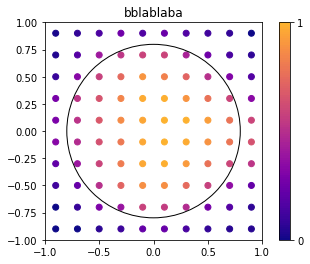

In [86]:
F_train = check_circle(X_train, optimal_parameters, simulator)
print(F_train)
tit='bblablaba'
fig=draw_circle((X_train, F_train), colorbar=True, title = tit)


However, at the end of the day we want a prediction for a point to be *IN* or *OUT*. We have to set a way to decide to which class a point belongs. As a first approach, we can apply a rule of maximum: if measuring $0$ is the most probable situation, then the point belongs to class $0$. The result we obtain using this method is depicted below. It is important to mention that this may be not the optimal rule. 

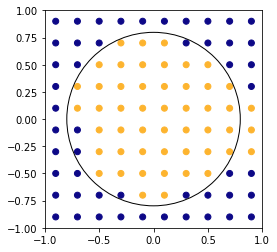

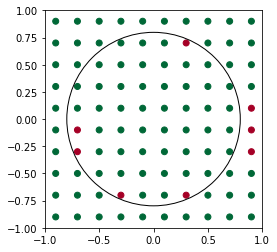

In [87]:
Z_train = np.round(F_train)

checks_train = (Z_train == Y_train).astype(int)
fig=draw_circle((X_train, Z_train), check=False)
fig=draw_circle((X_train, checks_train), check=True)

We are now about to check unseen data, and see how the classifier performs on unknown data. We first compute the fidelities. 

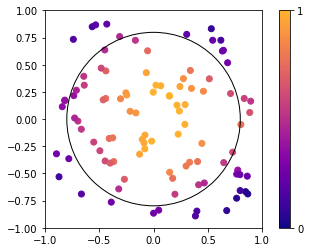

In [88]:
test=100
X_test = 1.8*np.random.rand(test, 2) - .9
Y_test = circle_labels(X_test)

F_test = check_circle(X_test, optimal_parameters, simulator)

fig=draw_circle((X_test, F_test), colorbar=True)

Now we have to decide to which class every point belongs. Instead of applying the rule of maximum, we will set a bias $p$, i.e.: if the probability of measuring $| 0 \rangle$ does not exceed $p$, the point belongs to class $0$. The optimal value $p$ can be computed by running over all possible different values of it.

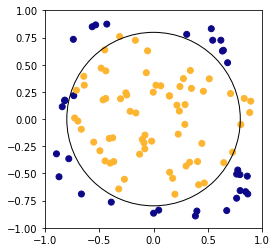

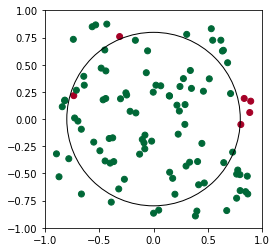

In [89]:
s_test, p_test = swipe_check(F_test, Y_test)

Z_test = (F_test > p_test).astype(int)
checks_test = (Z_test == Y_test).astype(int)
fig=draw_circle((X_test, Z_test), check=False)
fig=draw_circle((X_test, checks_test), check=True)

The moment of using an actual quantum device has arrived. We will create a `qtest` set of data and perform the same calculations as before. We use the bias obtained 

In [18]:
'''
qtest=20
X_qtest = 1.8*np.random.rand(qtest, 2) - .9
Y_qtest = circle_labels(X_qtest)

F_qtest = np.empty(len(X_qtest))
for i, x in enumerate(X_qtest):
    F_qtest[i]=check_circle(x, optimal_parameters, quantum_device)
'''


'\nqtest=20\nX_qtest = 1.8*np.random.rand(qtest, 2) - .9\nY_qtest = circle_labels(X_qtest)\n\nF_qtest = np.empty(len(X_qtest))\nfor i, x in enumerate(X_qtest):\n    F_qtest[i]=check_circle(x, optimal_parameters, quantum_device)\n'

In [19]:
'''
Z_qtest = (F_qtest > p_test).astype(int)
checks_qtest = (Z_qtest == Y_qtest).astype(int)
fig=draw_circle((X_qtest, F_qtest), colorbar=True) 
fig=draw_circle((X_qtest, checks_qtest), check=True)
'''

NameError: name 'F_qtest' is not defined

### Second problem: Classifying four quadrants

We want to deal now with a harder problem. The difficulty of the problem comes from the fact that now we want to classify points into four different labels. One qubit does not have four dimension in its Hilbert space, it is simply not possible to find four orthogonal states. 

We will show first a way to go through this fact. When the problem has been solved with one qubit, we will generalize it to a 2-qubits classifier



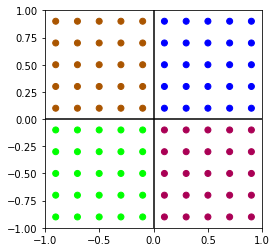

In [8]:
grid = 10
x = np.linspace(-.9,.9,grid)
X = list(itertools.product(x, x))
X_train = np.asfarray(X)
Y_train = squares_labels(X_train)

fig = draw_squares((X_train, Y_train))

#### The single-qubit solution: exploiting the infinite space of the Bloch sphere

As Richard Feynman said, *there is plenty of room at the bottom*. It is true that the dimension of the Hilbert space of one qubit is just $2$. However, the qubit can be in (formally) an infinite number of different configurations. We will take advantage of this fact to classify datasets with more than 2 classes. Instead of using the two poles of the Bloch sphere, we will use this list of states as the labels of our data:

$$
| \psi_0 \rangle = \begin{pmatrix}1 \\ 0  \end{pmatrix} \qquad
| \psi_1 \rangle = \begin{pmatrix}\sqrt{1/3} \\ \sqrt{2 / 3} \end{pmatrix}  \qquad
| \psi_2 \rangle = \begin{pmatrix}\sqrt{1/3} \\ \sqrt{2 / 3}e^{\frac{2\pi i}{3}} \end{pmatrix}  \qquad
| \psi_3 \rangle = \begin{pmatrix}\sqrt{1/3} \\ \sqrt{2 / 3}e^{\frac{-2\pi i}{3}} \end{pmatrix} \qquad
$$

These states are chosen for being the four verteices of a tetrahedron inscribed in the Bloch Sphere. This way, the four states are maximally orthogonal between them, and each dominates over the largest possible area. Notice that, for any state $|\phi\rangle$ this configuration satisfies that
$$
\sum_{i=0}^3 |\langle\phi|\psi_i\rangle|^2 = 2
$$

We can represent those states in the Bloch sphere using `qiskit`.

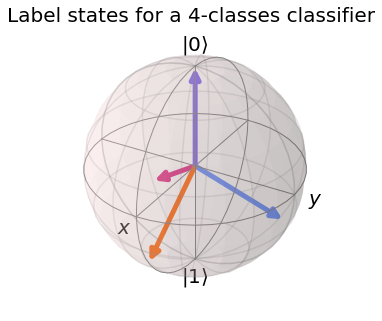

In [9]:
from qiskit.visualization import plot_bloch_vector
psi0=[0,0,1]
psi1=[np.sqrt(2/3), 0,-1/np.sqrt(3)]
psi2=[-np.sqrt(1/6),1/np.sqrt(2),-1/np.sqrt(3)]
psi3=[-np.sqrt(1/6),-1/np.sqrt(2),-1/np.sqrt(3)]
plot_bloch_vector([psi3, psi2, psi1, psi0], title='Label states for a 4-classes classifier', figsize=[4,4])

We define now the circuit, which is equivalent to the circuit in Fig. 4.  
<img src="4classes_1qubit.png" width="400"> 
*Fig. 4: Circuit for the classification of four quadrants. The $V_i$ gate represents the gate needed for creating all different $| \psi_i\rangle$ labelling the classes.*
<br>

In [10]:
def measurement_squares_1q(x, y, parameters, device):
    if len(parameters) % 5 != 0:
        raise ValueError('The number of parameters is not correct')
    layers = len(parameters) // 5
    parameters = parameters.reshape(layers, 5)
    C = QuantumCircuit(3,1)
    theta = 2 * np.arccos(1/np.sqrt(3))
    if y == 1:
        C.u3(theta, 0, 0, 1)
    elif y == 2:
        C.u3(theta, 2 * np.pi / 3, 0, 1)
    elif y == 3:
        C.u3(theta, -2 * np.pi / 3, 0, 1)

    C.h(2)
    for l in range(layers):
        C.u3(parameters[l,0] * x[0] + parameters[l, 1], parameters[l, 2] * x[1] + parameters[l, 3], parameters[l, 4], 0)

    C.cswap(2, 0, 1)
    C.h(2)

    C.measure([2], [0])
    C.draw()
    # Select the QasmSimulator from the Aer provider
    try:
        backend = Aer.get_backend(device)
    except:
        provider = IBMQ.get_provider()#hub='ibm-q')
        backend=provider.get_backend(device)

    # Execute and get counts
    sh = 1024
    result = execute(C, backend, shots=sh).result()
    counts = result.get_counts(C)
    fidelity = 2 * counts['0'] / sh - 1
    return fidelity

def check_squares_1q(x, parameters, device):
    Fidelities = np.zeros(4)
    for y in range(4):
        Fidelities[y] = measurement_squares_1q(x, y, parameters, device)
    #for y in range(2):
        #Fidelities[y] = measurement_circle(x, y, parameters, device)
        
    return Fidelities

def cost_function_squares_1q(parameters, X, Y, device):
        chi2 = 0
        for x, y in zip(X, Y):
            chi2 += (1 - measurement_squares_1q(x, y, parameters, device))**2
            
        return chi2 / len(Y)

In [26]:
layers=2
from scipy.optimize import minimize
parameters = np.random.rand(5*layers)

solution = minimize(cost_function_squares_1q,parameters, args=(X_train, Y_train, simulator), method='Powell')
solution

   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  

In [27]:
layers=3
from scipy.optimize import minimize
parameters = np.random.rand(5*layers)

solution3 = minimize(cost_function_squares_1q,parameters, args=(X_train, Y_train, simulator), method='Powell')
solution3

   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 

In [28]:
layers=4
from scipy.optimize import minimize
parameters = np.random.rand(5*layers)

solution4 = minimize(cost_function_squares_1q,parameters, args=(X_train, Y_train, simulator), method='Powell')
solution4

   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 

In [37]:
layers=5
from scipy.optimize import minimize
parameters = np.random.rand(5*layers)

solution5 = minimize(cost_function_squares_1q,parameters, args=(X_train, Y_train, simulator), method='Powell')
solution5

   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.

In [11]:
sol2= np.array([-0.238873  ,  0.96326096,  2.29141026, -0.39870389, -2.15164795,
       -1.92529151,  1.98063197,  0.50320325,  0.67590627,  1.28547386]) #0.04645973

sol3 = np.array([ 1.76920525, -1.2262498 ,  1.19195069,  1.4974693 ,  4.37513302,
       -0.03020798,  0.74452661,  1.88159056,  1.36368789,  0.64333014,
       -0.04983991,  1.1789682 , -0.48450897, -0.5229465 ,  0.48910178]) #0.02965569

sol4=np.array([ 2.75863799,  0.22982122, -2.84580892,  1.57901683, -5.08838378,
       -0.66882659,  0.48172774,  1.02222475,  0.56508846,  0.76367837,
        0.67683383,  1.42199148,  0.65057268,  0.84085959,  0.72407228,
        0.27771849,  0.61770242, -0.64734714,  1.03078973,  0.23884424]) #0.05747875
                
sol5=np.array([-2.2098064 ,  1.06829506,  0.04794565,  1.39550784,  8.67143781,
       -0.78979345, -0.26027616,  0.974604  ,  1.05659761,  0.63280086,
       -0.84336565,  0.62194456,  0.86780466,  0.76096462,  1.3995512 ,
        0.17556655,  0.66846998,  1.29947557,  0.50552334,  0.56689907,
       -0.31511069,  1.06892719, -0.09362675, -0.75897657,  0.6986746 ]) #0.0334993

In [33]:
optimal_parameters=sol2

In [34]:
F_train = np.empty((len(X_train), 4))
for i, x in enumerate(X_train):
    F_train[i]=check_squares_1q(x, optimal_parameters, simulator)

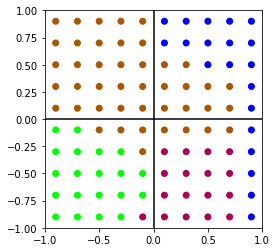

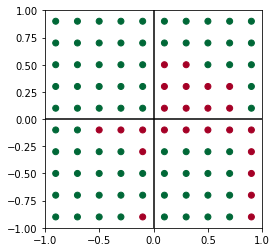

In [35]:
tit='Maximum fidelities'
fig=draw_squares((X_train, np.argmax(F_train, axis=1)))#, title = tit)

tit='Right / Wrong'
fig=draw_squares((X_train, (Y_train==np.argmax(F_train, axis=1)).astype(int)), check=True)#, title = tit)

Similar to previous, but with weights

In [36]:
def _weight_fidelities(f, w):
    return f*w

def cost_weights(w, Y, F):
    cost=0
    for f,y in zip(F, Y):
        f_ = np.argmax(_weight_fidelities(f,w))
        if f_ != y:
            cost += 1
            
    return cost / len(Y)
    
    
def weighted_fidelity(F, w):
    wF = np.empty(len(F))
    for i, f in enumerate(F):
        wF[i] = np.argmax(_weight_fidelities(f, w))
        
    return wF

In [37]:
test=100
X_test = 1.8*np.random.rand(test, 2) - .9
Y_test = squares_labels(X_test)

F_test = np.empty((test, 4))
for i, x in enumerate(X_test):
    F_test[i]=check_squares_1q(x, optimal_parameters, simulator)

In [38]:
result = minimize(cost_weights, np.ones(4), args=(Y_test, F_test), method='Powell')
opt_weights=result.x
opt_weights

array([1.32236839, 1.24523703, 0.88409854, 1.10853855])

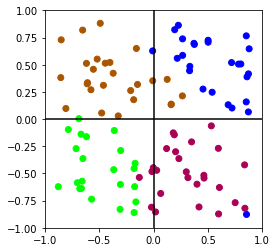

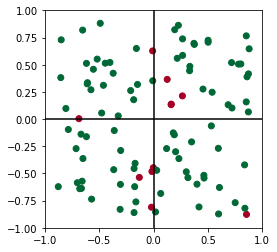

In [39]:
wF_test = weighted_fidelity(F_test, opt_weights)
tit='Maximum fidelities'
fig=draw_squares((X_test, wF_test))#, title = tit)

tit='Right / Wrong'
fig=draw_squares((X_test, (Y_test==wF_test).astype(int)), check=True)#, title = tit)

In [81]:
'''
qtest=20
X_qtest = 1.8*np.random.rand(qtest, 2) - .9
Y_qtest = squares_labels(X_qtest)

F_qtest = np.empty((len(X_qtest),4))
for i, x in enumerate(X_qtest):
    F_qtest[i]=check_squares_1q(x, optimal_parameters, quantum_device)

'''

'\nqtest=20\nX_qtest = 1.8*np.random.rand(qtest, 2) - .9\nY_qtest = squares_labels(X_qtest)\n\nF_qtest = np.empty((len(X_qtest),4))\nfor i, x in enumerate(X_qtest):\n    F_qtest[i]=check_squares_1q(x, optimal_parameters, quantum_device)\n\n'

In [ ]:
'''
wF_qtest = weighted_fidelity(F_qtest, opt_weights)
tit='Maximum fidelities'
fig=draw_squares((X_qtest, wF_qtest))#, title = tit)

tit='Right / Wrong'
fig=draw_squares((X_qtest, (Y_qtest==wF_qtest).astype(int)), check=True)#, title = tit)
'''

#### The double-qubit solution: there are four orthogonal states

Another possible strategy to solve this problem is using more qubits. For a 4 classes problem, a 2-qubit Hilbert space should be enough, and the label states become now

$$
| \psi_0 \rangle = | 00 \rangle \qquad
| \psi_1 \rangle = | 01 \rangle \qquad
| \psi_2 \rangle = | 10 \rangle \qquad
| \psi_3 \rangle = | 11 \rangle \qquad
$$

The circuit is then 
<img src="4classes_2qubit.png" width="300"> 
*Fig. 6: Circuit for the classification of four quadrants with 2 qubits. The $X?$ gates will appear depending on the class of the point.*
<br>

As now there are more qubits in the $U$ gate, we need to define the Ansatz we are about to use. This choice is heuristic, and there could be other Änsatze with better results. 

<img src="circuit_2q.png" width="300"> 
*Fig. 7: Circuit for the Ansatz for the classification of four quadrants with 2 qubits. The $L(i)$ gates are defined in the same way as before.*
<br>

In [40]:
def measurement_squares_2q(x, y, parameters, device):
    if len(parameters) % 10 != 0:
        raise ValueError('The number of parameters is not correct')
    layers = len(parameters) // 5 // 2
    qubits = 2
    parameters = parameters.reshape(qubits, layers, 5)
    C = QuantumCircuit(5,1)
    if y == 1:
        C.x(2)
    elif y == 2:
        C.x(3)
    elif y == 3:
        C.x(2)
        C.x(3)

    C.h(4)
    for l in range(layers - 1):
        for q in range(qubits):
            C.u3(parameters[q,l,0] * x[0] + parameters[q,l, 1],
                 parameters[q,l, 2] * x[1] + parameters[q,l, 3],
                 parameters[q,l, 2], q)
        C.cx(0,1)
    for q in range(qubits):
        C.u3(parameters[q,-1,0] * x[0] + parameters[q,-1, 1],
                 parameters[q,-1, 2] * x[1] + parameters[q,-1, 3],
                 parameters[q,-1, 2], q)

    C.cswap(4, 0, 2)
    C.cswap(4, 1, 3)
    C.h(4)

    C.measure([4], [0])
    C.draw()
    # Select the QasmSimulator from the Aer provider,
    simulator = Aer.get_backend(device)

    # Execute and get counts,
    sh = 1024
    result = execute(C, simulator, shots=sh).result()
    counts = result.get_counts(C)
    fidelity = 2 * counts['0'] / sh - 1
    return fidelity
    
def check_squares_2q(x, parameters, device):
    Fidelities = np.zeros(4)
    for y in range(4):
        Fidelities[y] = measurement_squares_2q(x, y, parameters, device)
    #for y in range(2):
        #Fidelities[y] = measurement_circle(x, y, parameters, device)
    return Fidelities

def cost_function_squares_2q(parameters, X, Y, device):
        chi2 = 0
        for x, y in zip(X, Y):
            chi2 += (1 - measurement_squares_2q(x, y, parameters, device))**2
            
        return chi2 / len(Y)

In [ ]:
layers=2
from scipy.optimize import minimize
parameters = np.random.rand(5*2*layers)

solution2 = minimize(cost_function_squares_2q,parameters, args=(X_train, Y_train, simulator), method='Powell')
solution2

In [ ]:
layers=3
from scipy.optimize import minimize
parameters = np.random.rand(5*2*layers)

solution3 = minimize(cost_function_squares_2q,parameters, args=(X_train, Y_train, simulator), method='Powell')
solution3

In [ ]:
layers=4
from scipy.optimize import minimize
parameters = np.random.rand(5*2*layers)

solution4 = minimize(cost_function_squares_2q,parameters, args=(X_train, Y_train, simulator), method='Powell')
solution4

In [ ]:
layers=5
from scipy.optimize import minimize
parameters = np.random.rand(5*2*layers)

solution5 = minimize(cost_function_squares_2q,parameters, args=(X_train, Y_train, simulator), method='Powell')
solution5

In [41]:
'''
sol2=np.array([ 4.45129067e+00, -1.56875684e+00,  2.01933558e+00,  1.77740136e-01,
        8.78500962e-01,  1.79047190e+00, -1.76865802e-01,  1.57838726e+00,
        6.54460664e+00,  6.83160045e+00,  2.39327399e+00,  8.27917274e-03,
        1.47120756e-01,  3.70576157e-01, -1.02111974e+01, -2.68658232e-01,
       -1.15105832e+00, -2.31561508e-02,  9.81351719e+00, -1.34449687e+01]) #0.2850864028930664

sol3=np.array([ 0.06607868, -1.47318115,  0.99179411,  0.0186335 , -1.54075934,
       -3.01268191,  1.32373749,  0.0093197 , -1.4604332 ,  3.10745051,
       -2.55232083, -0.25882256,  1.33968079, -2.80508489,  1.07697963,
        0.54669349,  0.75734084, -2.21788686,  1.57259574, -0.57289583,
        0.35731731,  0.44065143,  1.27718811,  0.22387249,  5.74286817,
        0.93791628,  0.12577838, -0.02754623, -0.42773836,  4.87704546]) #0.13968181610107422

sol4=np.array([ 3.1898398 , -0.37025668, -1.73674639,  0.84073677,  1.15224075,
       -1.36204783,  1.07326992,  1.5908699 , -0.35888521,  4.52392772,
        0.45898233,  1.43217251,  1.63209173,  0.11613165,  4.04809762,
        2.04014856,  0.37932187,  0.89549906,  2.08417428, -0.53604735,
       -0.57343669, -0.22951699,  0.60406831, -2.51368728,  6.62893304,
        0.13499539,  1.45433562, -0.37528303, -0.21841795, -5.37530558,
       -0.04217691, -0.13016771,  0.65035978,  0.0128586 ,  3.03076242,
        0.55152724, -0.4460519 ,  0.02672925,  0.43853393,  0.94828499]) #0.12033618927001953

sol5=np.array([ 8.28873173e-01,  5.88256808e-01,  2.22790220e+00, -2.13979916e-01,
       -4.16913127e-01, -1.94147125e+00,  9.26795999e-01,  6.09683748e-01,
        1.40645880e-01,  1.56835179e+01,  1.67211776e+00,  4.30853872e-01,
        4.02343415e-01, -1.53428227e-01,  4.35068647e+00,  8.07221883e-01,
        2.47212258e-01,  9.35398337e-01, -5.05220821e-01,  3.94402119e+00,
       -4.07666813e-01,  1.36728158e+00,  9.98978477e-01, -5.44535629e+01,
        1.17085417e+01, -6.06856233e-01,  2.73826664e-01, -3.53898263e-01,
        1.11934070e+00, -3.41848180e-01,  1.25177133e-02,  4.76414413e-01,
       -3.75213923e-01, -4.36393734e-01,  5.44883302e+01, -1.23180096e+00,
        1.10944978e+00,  7.28155127e-01,  3.98446907e-01,  6.03413819e+00,
        4.90540125e-02,  2.69410376e-01, -3.18790950e-01,  6.67271477e-01,
        2.41327405e+00,  3.46193861e-01, -7.06961704e-01,  4.32356569e-01,
        1.00982334e+00,  3.33594588e+00]) #0.10045291900634766
'''

sol2=np.array([-2.20265636,  2.79471397,  2.54321346,  1.37312146,  1.95988804,
        2.33302126, -0.06746737,  3.53582644,  3.70306531,  7.6379535 ,
       -0.2843605 , -1.43530903,  0.32061818, -0.12635673,  3.75360392,
        2.29964482,  0.10778855, -0.23060531,  6.08550437, -0.54738107]) #0.21515789

sol3=np.array([ 3.47813393,  0.64819829,  0.09791011, -0.07433901,  0.27712308,
        0.45377954, -1.70803136,  2.65017691, -2.64260395,  1.6074981 ,
        0.20364395,  1.51230856,  1.07097085,  6.31273712,  5.05560192,
        0.20761338,  0.10646259, -0.88030422, -1.18006596,  2.24593026,
        0.39980176,  1.44930848,  0.28509367,  0.20137774,  5.25494014,
        1.06698751,  0.80751445,  0.33848533, -1.13561511,  0.45219415]) #0.0991209

sol4=np.array([ 4.26675591e+00, -1.81609447e+00,  1.53513339e-01,  2.51276160e+00,
        2.28947915e+01, -9.84734745e-02,  1.56749940e+00,  9.13421183e-01,
       -1.08641527e+00,  2.24133067e+01,  1.18970760e+00,  3.41846350e-01,
        1.23054927e+00, -9.58573530e-01,  2.15514341e+00, -2.21483920e-01,
        1.54406871e+00,  8.18492859e-01,  1.23564616e+01,  1.33075776e+01,
        8.20629532e-01,  1.68689978e-01,  2.97066124e+00, -9.03819244e-01,
        2.33757261e+01,  2.35193527e-01,  5.54222172e-02,  9.91554020e-02,
        1.09013181e+00,  2.39278069e+01,  1.23765919e+00,  2.15855983e-01,
        3.45400188e-02,  1.46340436e+00,  2.75949255e+01,  2.12891923e+00,
       -3.13271174e-01,  1.98699299e-01,  6.91957452e+01,  1.42565613e+01]) #0.09918545

sol5=np.array([-0.5503    ,  2.32168178, -0.4770827 ,  1.36304786,  5.75830031,
        1.27595282, -0.01371866,  0.70249158,  0.72840947, -7.23307759,
        2.25770189,  0.08036987,  0.28766895,  0.83549721, -2.15890149,
        0.76227038,  1.5283648 ,  1.85614651,  0.32155202, -1.4890198 ,
        0.36860082,  1.52361716,  1.03213059, -4.56708327,  9.16019237,
        1.00515681, -0.2757775 , -0.13081037,  0.10170478, -7.11245416,
        0.20489769,  1.10649647,  0.05310931, -0.37776734,  8.01188209,
        1.45759797,  0.1684235 ,  0.58199745, -0.05697979,  2.82258146,
        0.34481144,  0.14256562,  0.74283004,  0.22402758,  4.52567825,
        1.40171871, -0.54045482,  0.33380917,  4.56057391,  4.63033002]) #0.09383938

In [69]:
optimal_parameters=sol5


F_train = np.empty((len(X_train), 4))
for i, x in enumerate(X_train):
    F_train[i]=check_squares_2q(x, optimal_parameters, simulator)

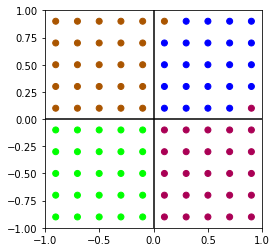

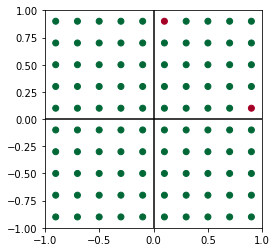

In [70]:
tit='Maximum fidelities'
fig=draw_squares((X_train, np.argmax(F_train, axis=1)))#, title = tit)

tit='Right / Wrong'
fig=draw_squares((X_train, (Y_train==np.argmax(F_train, axis=1)).astype(int)), check=True)#, title = tit)

In [59]:
test=100
X_test = 1.8*np.random.rand(test, 2) - .9
Y_test = squares_labels(X_test)

F_test = np.empty((len(X_test), 4))
for i, x in enumerate(X_test):
    F_test[i]=check_squares_2q(x, optimal_parameters, simulator)

In [60]:
result = minimize(cost_weights, np.ones(4), args=(Y_test, F_test), method='Powell')
opt_weights=result.x
opt_weights

array([1.38854383, 1.        , 0.96582494, 0.98660562])

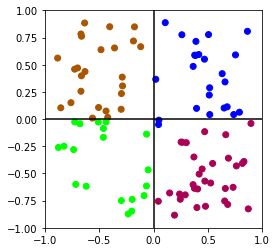

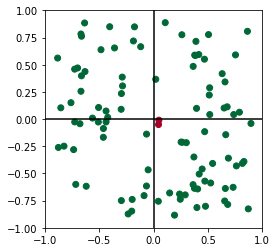

In [61]:
wF_test = weighted_fidelity(F_test, opt_weights)
tit='Maximum fidelities'
fig=draw_squares((X_test, wF_test))#, title = tit)

tit='Right / Wrong'
fig=draw_squares((X_test, (Y_test==wF_test).astype(int)), check=True)#, title = tit)

[1] Pérez-Salinas, A., Cervera-Lierta, A., Gil-Fuster, E., & Latorre, J. I. (2019). *Data re-uploading for a universal quantum classifier.* arXiv preprint [arXiv:1907.02085](https://arxiv.org/abs/1907.02085)<br>
[2] Zhao, Z., Pozas-Kerstjens, A., Rebentrost, P., & Wittek, P. (2019). *Bayesian deep learning on a quantum computer.* Quantum Machine Intelligence, 1(1-2), 41-51. [arXiv:1806.11463](https://arxiv.org/abs/1806.11463).<br>
[3] Biamonte, J., Wittek, P., Pancotti, N., Rebentrost, P., Wiebe, N., & Lloyd, S. (2017). *Quantum machine learning.* Nature, 549(7671), 195.<br>
[4] Rebentrost, P., Mohseni, M., & Lloyd, S. (2014). *Quantum support vector machine for big data classification.* Physical review letters, 113(13), 130503.<br>
[5] Mitarai, K., Negoro, M., Kitagawa, M., & Fujii, K. (2018). *Quantum circuit learning.* Physical Review A, 98(3), 032309.<br>
[6] Schuld, M., Bocharov, A., Svore, K., & Wiebe, N. (2018). *Circuit-centric quantum classifiers.* arXiv preprint arXiv:1804.00633.<br>
[7] Nielsen, M. A., & Chuang, I. (2002). *Quantum computation and quantum information.*<br>